In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
import plotly.express as px

from itertools import chain
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch import nn
from tqdm.auto import trange

from mcpt.contrastlearning import WeightedCosineSimilarityLoss, ContrastLoss2

In [2]:
def plot_embeddings(embedding, labels):
    embedding = embedding.detach().numpy()
    if embedding.shape[0] > 2:
        pca = PCA(n_components=2)
        embedding = pca.fit_transform(embedding)
    labels = labels.t().numpy()
    fig, ax = plt.subplots()
    x, y = embedding.T
    ax.scatter(x[labels[1] == 0], y[labels[1] == 0], s=100, c='#e7d9a5ff', marker='s')
    ax.scatter(x[labels[1] == 1], y[labels[1] == 1], s=100, c='#f5c211ff', marker='s')
    xl, xr = ax.get_xbound()
    shift = (xr - xl) / 90
    ax.scatter(x[labels[0] == 0]-shift, y[labels[0] == 0], s=100, c='#e6aeaeff', marker='s')
    ax.scatter(x[labels[0] == 1]-shift, y[labels[0] == 1], s=100, c='#ed333bff', marker='s')
    ax.scatter(x[labels[2] == 0]+shift, y[labels[2] == 0], s=100, c='#9db3cdff', marker='s')
    ax.scatter(x[labels[2] == 1]+shift, y[labels[2] == 1], s=100, c='#1c71d8ff', marker='s')
    #ax.scatter(x[labels[3] == 0]+2*shift, y[labels[3] == 0], s=100, c='#96aa8aff', marker='s')
    #ax.scatter(x[labels[3] == 1]+2*shift, y[labels[3] == 1], s=100, c='#3c9b01ff', marker='s')

    #for i in range(len(x)):
    #    ax.annotate(str(i+1), (x[i], y[i]))

In [3]:
n_classes = 3
embedding_dim = 3
n_with_x_labels = [20, 8, 8]
n = np.sum(n_with_x_labels)
rng = np.random.default_rng(seed=42)
embeddings = torch.tensor(rng.random((n, embedding_dim)), requires_grad=True)
labels = []
for x, n_with_x in enumerate(n_with_x_labels):
    for i in range(n_with_x):
        labels.append(list(rng.choice(np.arange(n_classes), size=x+1, replace=False)))
binarizer = MultiLabelBinarizer()
labels = torch.tensor(binarizer.fit_transform(labels), dtype=torch.float32)

In [4]:
color_dict = {
    4: '#ff0000',
    2: '#00ff00',
    1: '#0000ff',
    5: '#ff00ff',
    6: '#ffff00',
    3: '#00ffff',
    7: '#ffffff',
}
labels_np = labels.int().numpy()
labels_np.T[0] <<= 2
labels_np.T[1] <<= 1

(-0.6293092610685878,
 0.6856271884797497,
 -0.5835039644014033,
 0.6845175424900941)

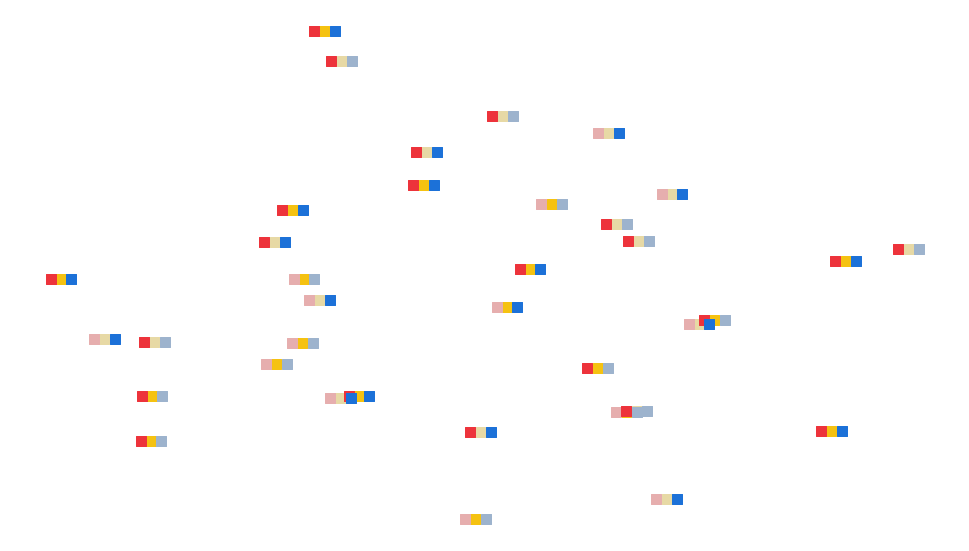

In [5]:
plot_embeddings(embeddings, labels)
plt.tight_layout()
#plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False, grid_alpha=1)
plt.axis('off')
#plt.savefig('figures/toy_embeddings_3d_untrained.pdf')

In [6]:
df_untrained = pd.DataFrame(embeddings.detach().numpy())
df_untrained['color'] = [color_dict[c] for c in labels_np.sum(axis=1)]
df_untrained.head(3)

,0,1,2,color
0,0.773956,0.438878,0.858598,#ff0000
1,0.697368,0.094177,0.975622,#ff0000
2,0.761140,0.786064,0.128114,#00ff00


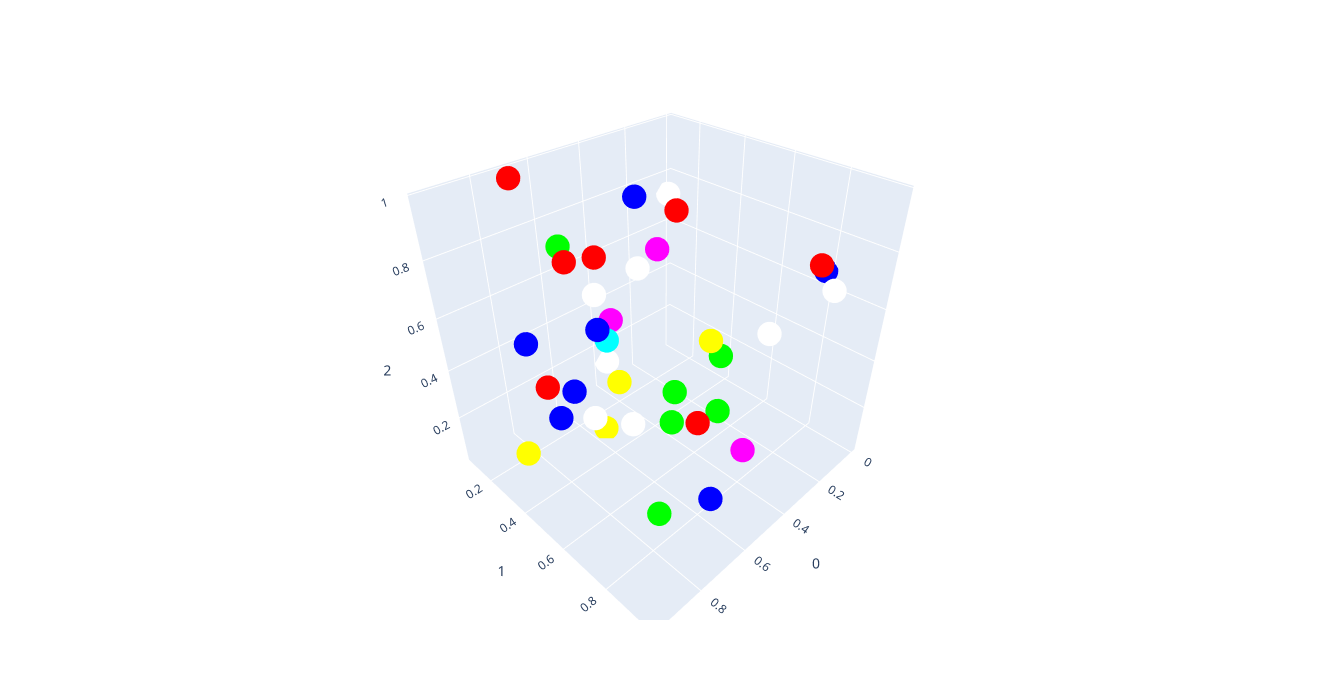

In [12]:
px.scatter_3d(df_untrained, x=0, y=1, z=2, color='color', color_discrete_map='identity', height=700, width=1200)

# WCSL

In [36]:
embeddings_wcsl = embeddings.detach().clone().requires_grad_(True)
WCSL = WeightedCosineSimilarityLoss(n_classes)
optimizer = torch.optim.SGD([embeddings_wcsl], lr=1e-2, momentum=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

  0%|          | 0/10000 [00:00<?, ?it/s]

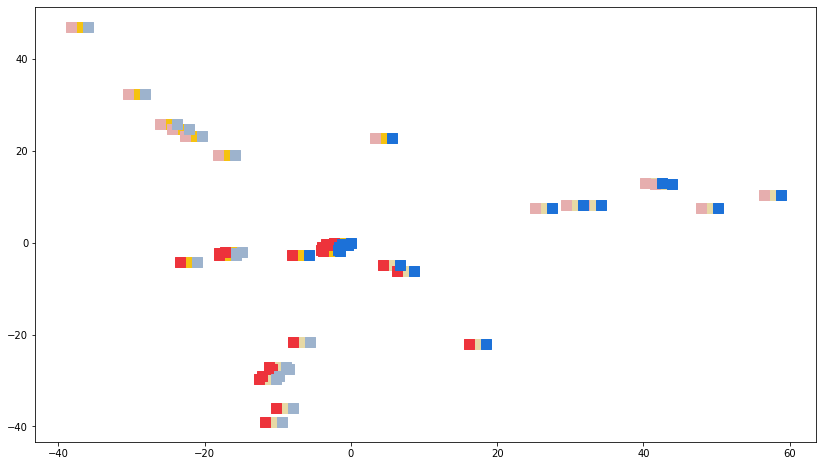

In [37]:
losses_wcsl = []
for i in trange(10000):
    loss = WCSL(embeddings_wcsl, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_wcsl.append(loss.detach())
    optimizer.zero_grad()
plot_embeddings(embeddings_wcsl, labels)

In [9]:
df_wcsl = pd.DataFrame(embeddings_wcsl.detach().numpy())
df_wcsl['color'] = [color_dict[c] for c in labels_np.sum(axis=1)]
df_wcsl.head(3)

,0,1,2,color
0,-11.710845,1.239075,14.585784,#ff0000
1,-10.248628,3.051156,13.451711,#ff0000
2,-5.935002,11.466305,-17.497452,#00ff00


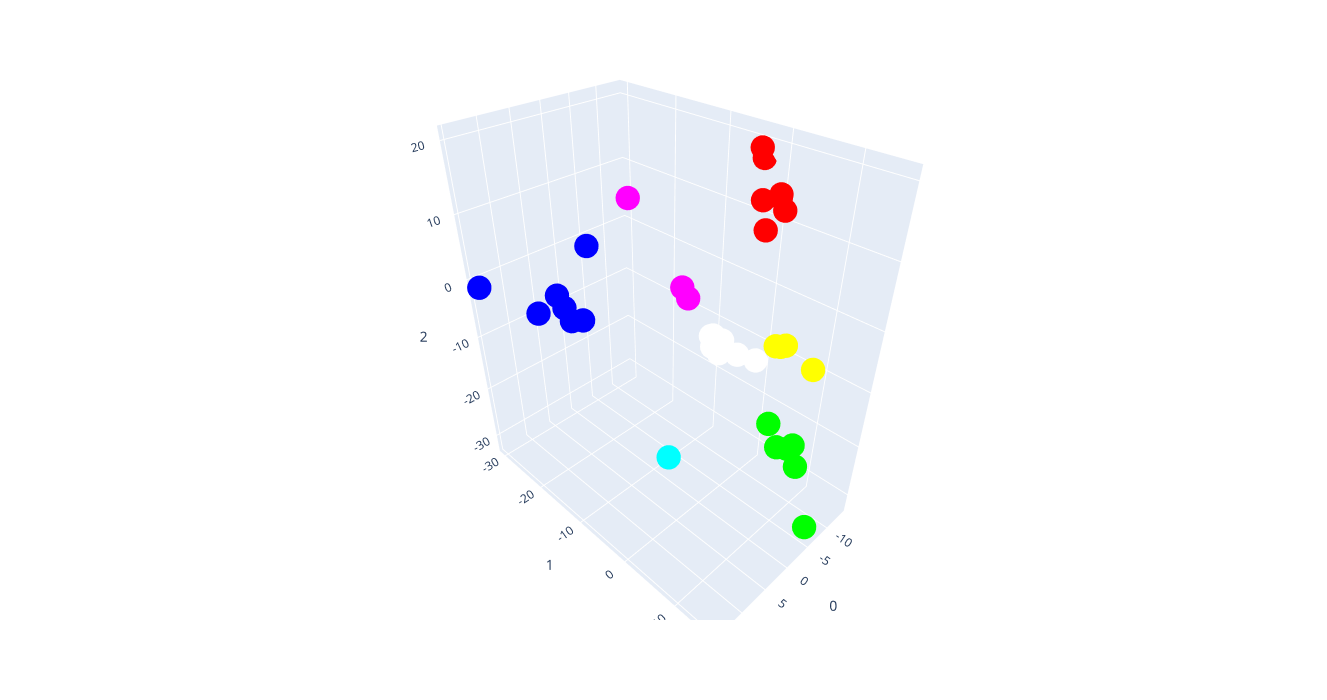

In [21]:
px.scatter_3d(df_wcsl, x=0, y=1, z=2, color='color', color_discrete_map='identity', height=700, width=1200)

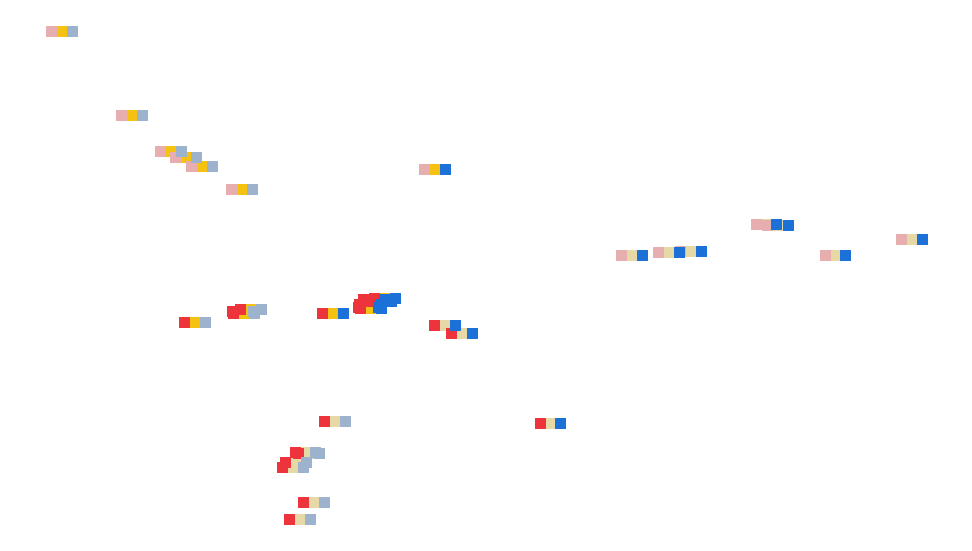

In [39]:
plot_embeddings(embeddings_wcsl, labels)
plt.tight_layout()
plt.axis('off')
plt.savefig('figures/toy_embeddings_3d_trained.pdf')

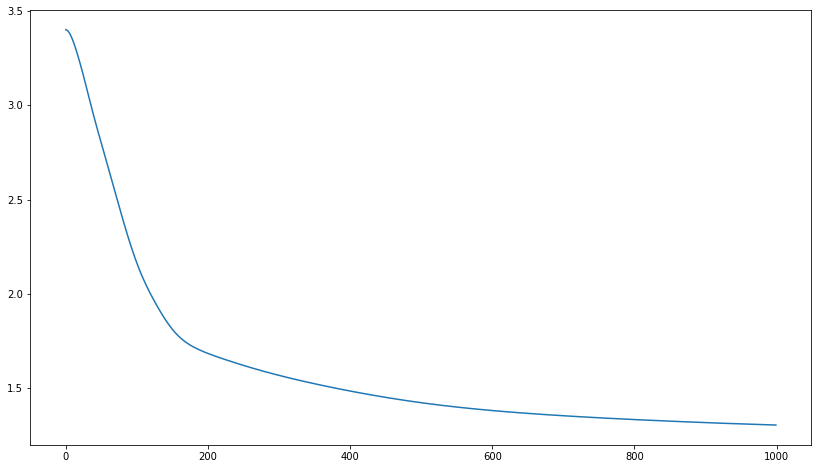

In [11]:
plt.plot(losses_wcsl)
plt.show()

# Contrast Loss 2

In [30]:
embeddings_cl2 = embeddings.detach().clone().requires_grad_(True)
CL2 = ContrastLoss2()
optimizer = torch.optim.SGD([embeddings_cl2], lr=1e-2, momentum=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

  0%|          | 0/10000 [00:00<?, ?it/s]

(tensor(0.2750, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(14.1474, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(11.1994, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(8.1120, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.4747, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.4787, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.5659, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.6208, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.6470, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))
(tensor(7.6584, dtype=torch.float64), tensor(0.4975, dtype=torch.float64))


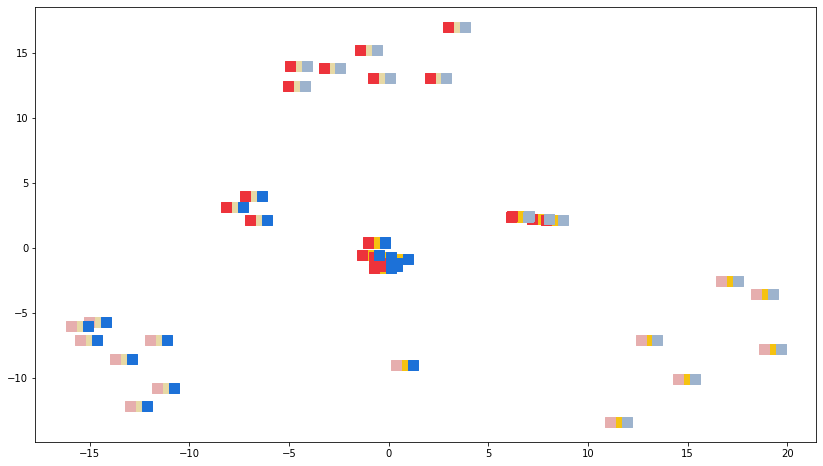

In [31]:
losses_cl2 = []
for i in trange(10000):
    loss = CL2(embeddings_cl2, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_cl2.append(loss.detach())
    optimizer.zero_grad()
    if not i % 1000:
        with torch.no_grad():
            print(torch.std_mean(embeddings_cl2))
plot_embeddings(embeddings_cl2, labels)

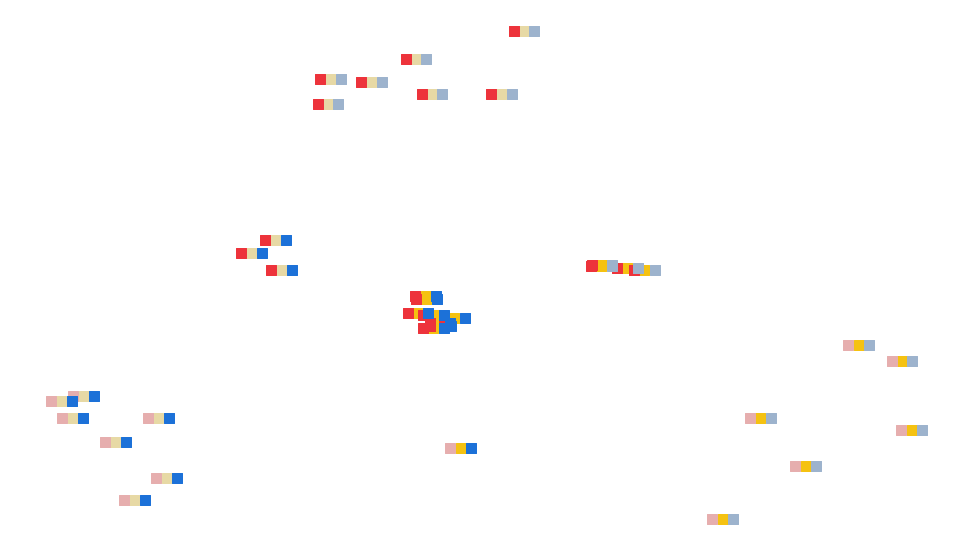

In [38]:
plot_embeddings(embeddings_cl2, labels)
plt.tight_layout()
plt.axis('off')
plt.savefig('figures/toy_embeddings_3d_trained_cl2.pdf')

In [33]:
torch.std_mean(embeddings_cl2)

(tensor(7.6632, dtype=torch.float64, grad_fn=<StdMeanBackward0>),
 tensor(0.4975, dtype=torch.float64, grad_fn=<StdMeanBackward0>))

In [34]:
torch.std_mean(embeddings_wcsl)

(tensor(10.8640, dtype=torch.float64, grad_fn=<StdMeanBackward0>),
 tensor(0.8168, dtype=torch.float64, grad_fn=<StdMeanBackward0>))

In [35]:
torch.std_mean(embeddings)

(tensor(0.2750, dtype=torch.float64, grad_fn=<StdMeanBackward0>),
 tensor(0.4975, dtype=torch.float64, grad_fn=<StdMeanBackward0>))

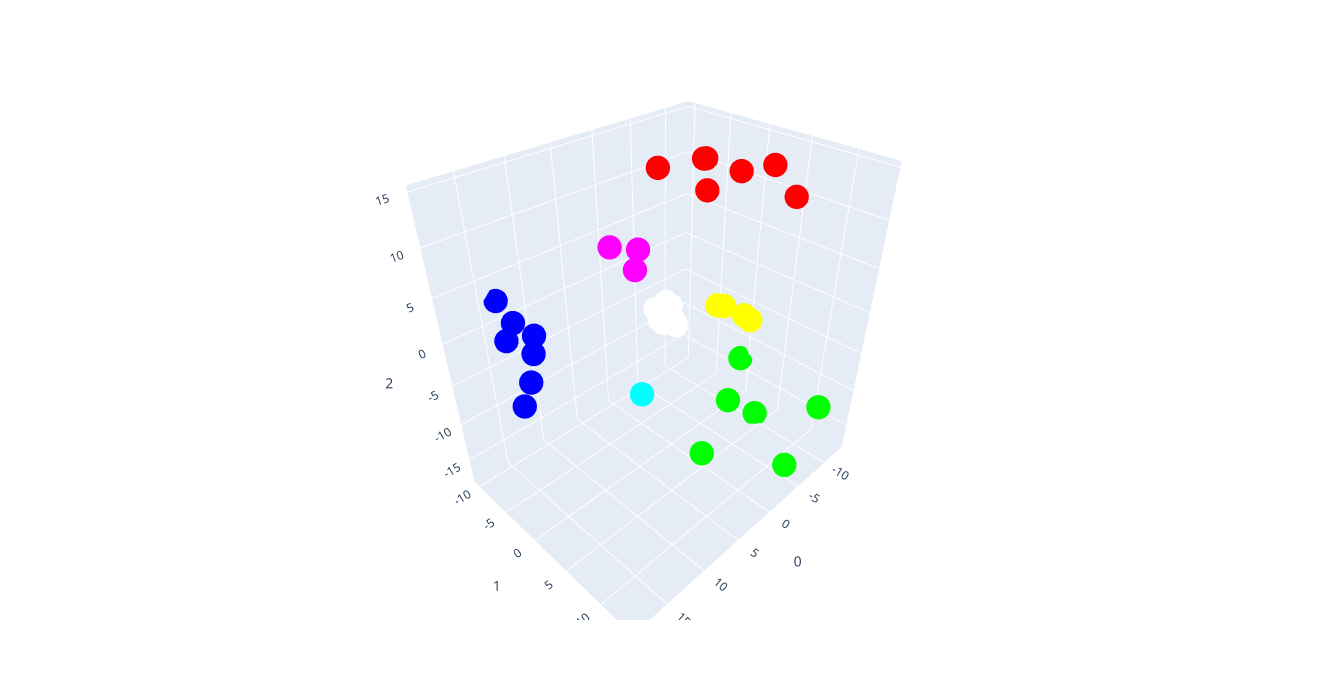

In [26]:
df_cl2 = pd.DataFrame(embeddings_cl2.detach().numpy())
df_cl2['color'] = [color_dict[c] for c in labels_np.sum(axis=1)]
px.scatter_3d(df_cl2, x=0, y=1, z=2, color='color', color_discrete_map='identity', height=700, width=1200)

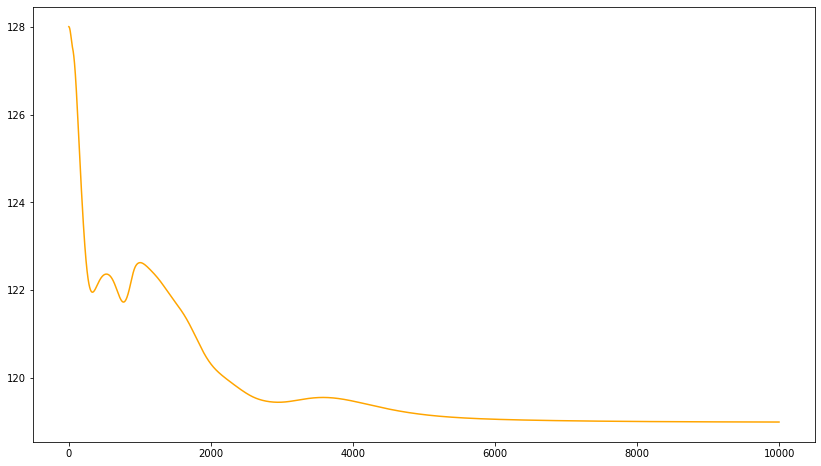

In [27]:
plt.plot(losses_cl2, c='orange')
plt.show()

# Combined

In [28]:
embeddings_combined = embeddings.detach().clone().requires_grad_(True)
WCSL = WeightedCosineSimilarityLoss(n_classes)
CL2 = ContrastLoss2()
optimizer = torch.optim.SGD([embeddings_combined], lr=1e-2, momentum=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

  0%|          | 0/1000 [00:00<?, ?it/s]

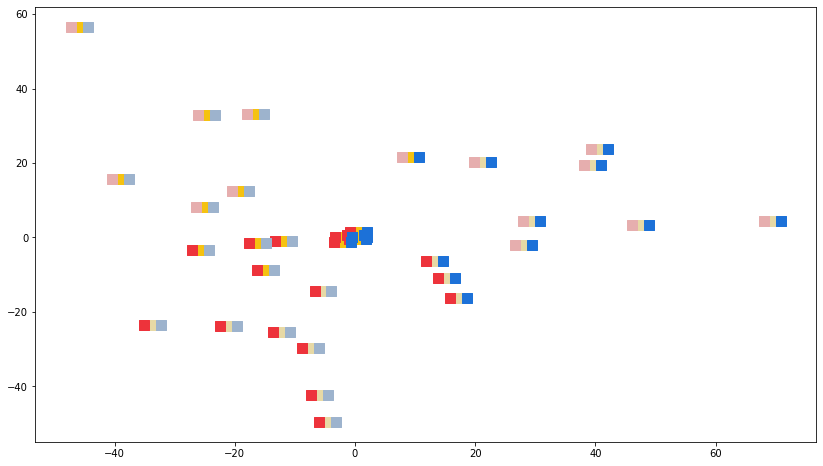

In [30]:
losses_wcsl = []
losses_cl2 = []
for i in trange(1000):
    loss_wcsl = WCSL(embeddings_combined, labels)
    loss_cl2 = CL2(embeddings_combined, labels)
    loss = 0.9*loss_wcsl + 0.1*loss_cl2
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_wcsl.append(loss_wcsl.detach())
    losses_cl2.append(loss_cl2.detach())
    #if not i % 1000:
        #plot_embeddings(embeddings_combined, labels)
        #print(embeddings_combined.grad)
    optimizer.zero_grad()
plot_embeddings(embeddings_combined, labels)

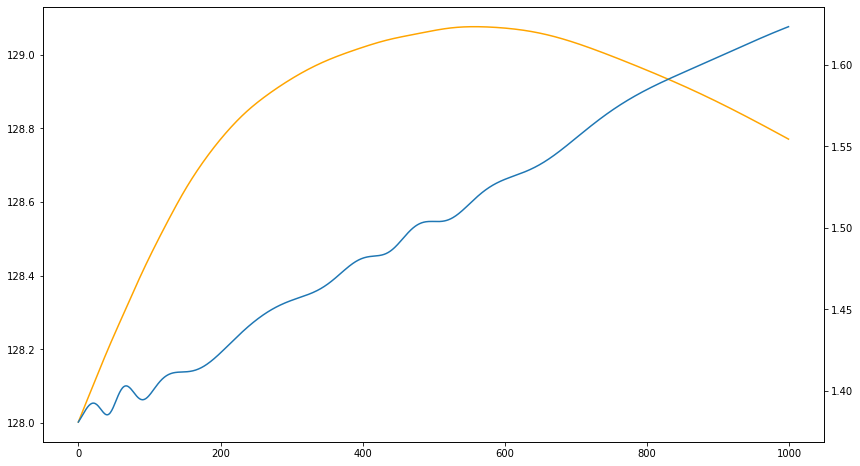

In [31]:
fig, ax1 = plt.subplots()
ax1.plot(losses_cl2, label='CL2', c='orange')
ax2 = ax1.twinx()
ax2.plot(losses_wcsl, label='WCSL')
plt.show()

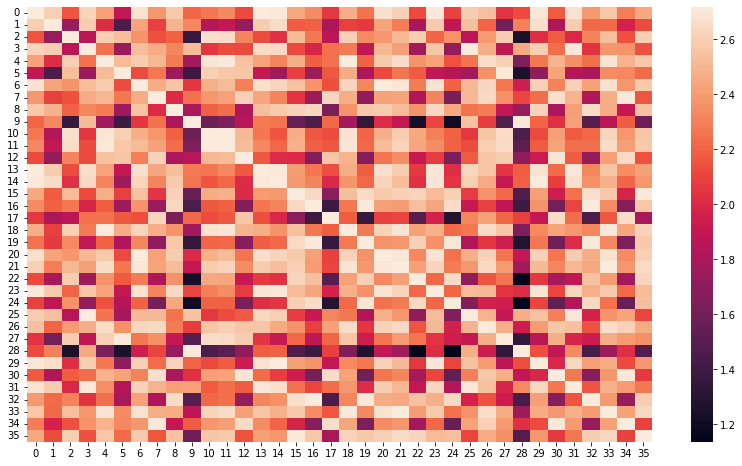

In [32]:
sns.heatmap(WCSL.exp_cosine_sim(embeddings, embeddings).detach().numpy())
plt.show()

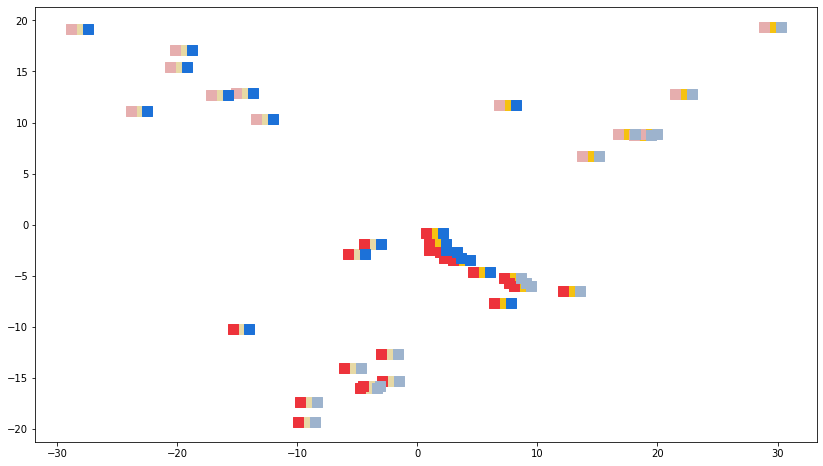

In [33]:
plot_embeddings(embeddings_wcsl, labels)

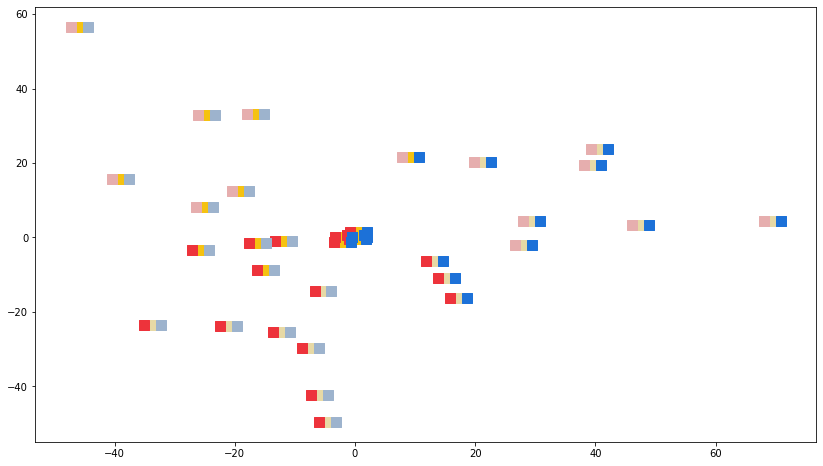

In [34]:
plot_embeddings(embeddings_combined, labels)

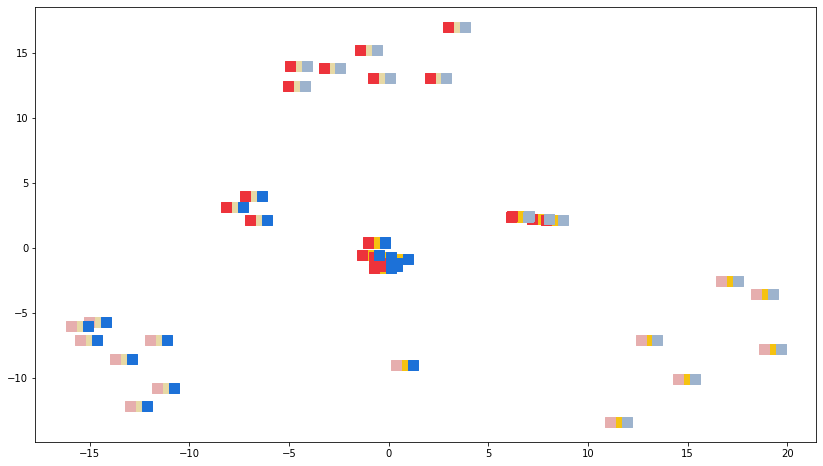

In [35]:
plot_embeddings(embeddings_cl2, labels)